In [ ]:
import os
seed = 40
os.environ['PYTHONHASHSEED']=str(seed)

import random
import seaborn as sns
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import *
style.use('ggplot')
import pandas as pd
import numpy as np
import time
import torch.profiler
import torch.autograd.profiler as profiler
from scipy import stats as st
import sklearn.preprocessing as preprocess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
import torch.optim as optim
import optuna



random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Context Integrated RNN - CiRNN

In [ ]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class ContextGRU(torch.nn.Module):
    """
     simple GRU cell network
    """

    def __init__(self, input_dim, hidden_dim, output_dim, context_dim):
        super(ContextGRU, self).__init__()

        self.n_x = input_dim
        self.n_h = hidden_dim
        self.n_y = output_dim
        self.n_z = context_dim
        #self.m = 20  #dimension of basis function vector (polynomial features) for 5 context features
        #self.m = 9  #dimension of basis function vector (polynomial features) for 3 context features
        self.m = 5  #dimension of basis function vector (polynomial features) for 2 context features
        #self.m = 14  #dimension of basis function vector (polynomial features) for 4 context features



        # reset gate components
        self.linear_reset_w1 = nn.Linear(self.n_x * self.m, self.n_h, bias=True)
        self.linear_reset_r1 = nn.Linear(self.n_h, self.n_h, bias=True)


        self.linear_reset_w2 = nn.Linear(self.n_x * self.m, self.n_h, bias=True)
        self.linear_reset_r2 = nn.Linear(self.n_h, self.n_h, bias=True)
        self.activation_1 = nn.Sigmoid()

        # update gate components
        self.linear_gate_w3 = nn.Linear(self.n_x * self.m, self.n_h, bias=True)
        self.linear_gate_r3 = nn.Linear(self.n_h, self.n_h, bias=True)
        self.activation_2 = nn.Sigmoid()

        self.activation_3 = nn.Tanh()

        #output
        self.linear_output = nn.Linear(self.n_h, self.n_y, bias=True)


    def reset_gate(self, xg, h):  #xg is the kronecker product of x and  basis function G(z)
        x_1 = self.linear_reset_w1(xg)
        h_1 = self.linear_reset_r1(h)
        # gate update
        r = self.activation_1(x_1 + h_1)
        return r

    def update_gate(self, xg, h):
        x_2 = self.linear_reset_w2(xg)
        h_2 = self.linear_reset_r2(h)
        s = self.activation_2( h_2 + x_2)
        return s


    def update_component(self, xg, h, r):
        x_3 = self.linear_gate_w3(xg)
        h_3 = r * self.linear_gate_r3(h)
        h_tilda = self.activation_3(x_3+h_3)
        return h_tilda


    def compute_output(self,h):
        y_pred = self.linear_output(h)
        return y_pred


    def cell_forward(self, x, h, G):

        """
        Implements a single forward step of the Context GRU-cell

        Input Arguments:
            x (mini-batch): input x at time step t , (n,n_x) : (batch_size, input_dim)
            h : hidden state at time step t-1, (n,n_h) : (batch_size, hidden_dim)
            G : vector of basis funcitons (m,n)

        Returns:
            h_new: hidden state at time step t, (n,n_h)

        """

        # kronecker product of x and G(zt)
        n = x.shape[0]
        xg = torch.zeros(n,self.n_x*self.m).to(device)

        for i in range(n):

            xg[i,:] = torch.kron(x[i,:],G[:,i])


        # Equation 1. reset gate vector
        r = self.reset_gate(xg, h)

        # Equation 2: the update gate - the shared update gate vector z
        s = self.update_gate(xg, h)

        # Equation 3: The almost output component
        h_tilda = self.update_component(xg,h,r)

        # Equation 4: the new hidden state
        h_new = (1-s) * h_tilda  + s * h

        #output

        y_pred = self.compute_output(h)

        return h_new, y_pred


    def forward(self, x, z):

        """
        Implement the forward propagation of the recurrent neural network

        Input Arguments:
        x (mini_batch): primary input for every time-step in mini-batches of shape (n, T, n_x)
        z (mini_batch): context input for every time-step in mini-batches of shape (n,T,n_z)


        Returns:
            h -- Hidden states for every time-step, numpy array of shape (n, T, n_h)
            y_pred -- Predictions for every time-step, numpy array of shape (n, T, n_y),
            here T is 1 for Seq to Vec RNN
        """


        # Retrieve dimensions from shapes of x
        #print(x.shape)
        #print(z.shape)
        n,T,n_x = x.shape
        n_y = self.n_y
        n_h = self.n_h
        n_z = self.n_z



        # initialize "h"

        h = self.init_hidden(n,T,n_h)

        #y_pred = np.zeros((m,T_x,n_y))
        #y_pred is single value for one sample, m=1




        #basis function vector
        G = self.apply_basis(z[:,0,:])  #G: size of (n,m)

        #for initial time step the hidden state is 0
        h_temp = h.clone()
        h_init = h_temp[:,0,:]
        h_curr, y_curr = self.cell_forward(x[:,0,:],h_init,torch.t(G))

        # loop over all time-steps
        for t in range(1,T):

            #compute the vector of basis functions


            G = self.apply_basis(z[:,t,:])  #G: size of (n,m)

            # Update next hidden state
            # ignore yt_pred for seq to vector
            h[:,t,:]= h_curr
            h_temp = h.clone()
            h_prev = h_temp[:,t,:]  #h_prev: (n,n_h)
            h_curr, y_curr = self.cell_forward(x[:,t,:],h_prev, torch.t(G))

            #y_pred[t,:] = yt_pred


        #compute the predicted output from the last cell i.e at last time step T
        y_pred = torch.zeros(n,1,1,device = 'cuda:0')

        #get the value of y_pred from the last cell
        y_pred[:,0,:] = y_curr

        #print(y_pred.shape)



        return h, y_pred


    def init_hidden(self, n:int,T:int, n_h:int):
        #initialise the hidden state
        #n : batch-size
        #T : Input sequence length
        #returns h of size (n,T,n_h)
        return torch.zeros(n,T,n_h,device = 'cuda:0')


    def apply_basis(self,zt):
        '''
        apply the basis function: polynomial degree 2
        [z0, z1, z2, z0z0, z0z1, z0z2....]
        input arguments:
            zt: context vector (n,n_z) for mini-batch of size n and n_z context dim
        Returns:
            G : tensor of basis functions, (m,n)

        for 5 context features m = 20
        '''

        #print(zt)
        #poly = PolynomialFeatures(2, include_bias=False, interaction_only=True)
        poly = PolynomialFeatures(2, include_bias=False)
        #print(poly.fit_transform(zt.cpu().numpy()).shape)
        G = torch.tensor(poly.fit_transform(zt.cpu().numpy())).to(device) #fit_transform returns nd array




        return G




Using cuda device


In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.weights = []      #used for visualising weights
        self.settings = []     #saving settings for visualising weights
        self.inputs = []       #saving input for visualising

    def train_step(self, x, y, z):



       # with profiler.record_function("TRAIN STEP FUNCTION"):
        # Sets model to train mode
        self.model.train()



        # Makes predictions
        h, yhat = self.model(x, z)


        # Computes loss
        loss = self.loss_fn(y, yhat)

        #with profiler.record_function("LOSS_BACKWARD"):
        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss

        return loss.item()

    def train(self, train_loader, val_loader, batch_size, n_epochs=50, np_features=1, nc_features=1):
        '''
        np_features = # primary input features
        nc_features = # context input features
        '''
        #model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        times = []
        for epoch in range(1, n_epochs + 1):

            start_epoch = time.time()

            batch_losses = []
            batch_count = 0
            for x_batch, z_batch, y_batch in train_loader:
                batch_count += 1

                x_batch = x_batch.view([batch_size,-1, np_features]).to(device)
                y_batch = y_batch.to(device)
                z_batch = z_batch.view([batch_size,-1, nc_features]).to(device)


                #with profiler.profile(with_stack=True, profile_memory=True) as prof:
                loss = self.train_step(x_batch, y_batch, z_batch)
                #print(prof.key_averages(group_by_stack_n=5).table(sort_by = 'self_cpu_time_total', row_limit = 5))

                batch_losses.append(loss)

    #             if (epoch % 10 == 0):
    #                     #if (batch_count % 200 == 0):
    #                         #save the model weights for each batch for analysis
    #                         #self.save_model(self.model, batch_count, str(z_batch[-1,:,:].detach().cpu().numpy()))
    #                 for param_tensor in model.state_dict():
    #                     if (param_tensor == 'linear_reset_w1.weight'):
    #                         param_val = model.state_dict()[param_tensor].cpu().numpy().tolist()
    #                         self.weights.append(param_val)
    #                         self.settings.append(z_batch[-1,:,:].detach().cpu().numpy().tolist())
                #self.model.to(device)


            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)





            with torch.no_grad():
                batch_val_losses = []
                for x_val, z_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, np_features]).to(device, non_blocking=True)
                    y_val = y_val.to(device)
                    z_val = z_val.view([batch_size, -1, nc_features]).to(device,non_blocking=True)

                    self.model.eval()

                    # with profiler.profile(with_stack=True, profile_memory=True) as prof:
                    h,yhat = self.model(x_val, z_val)
                    # print(prof.key_averages(group_by_stack_n=5).table(sort_by = 'self_cpu_time_total', row_limit = 5))

                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch % 5 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )



            torch.cuda.synchronize()
            end_epoch = time.time()
            elapsed = end_epoch - start_epoch
            times.append(elapsed)

        total_time = sum(times)
        avg_time = sum(times)/n_epochs

        print(f"Average Training time: {avg_time:.4f} s for epochs {n_epochs}")

        print(f"Total Training time: {total_time:.4f} s for epochs {n_epochs}")


        #torch.save(self.model.state_dict(), model_path)

        return validation_loss  #this will be used by otuna to optimize

    def evaluate(self, test_loader, batch_size=1, np_features=1, nc_features = 1):
            with torch.no_grad():
                predictions = []
                values = []
                for x_test, z_test, y_test in test_loader:

                    x_test = x_test.view([batch_size,-1, np_features]).to(device, non_blocking=True)
                    y_test = y_test.to(device)
                    z_test = z_test.view([batch_size,-1, nc_features]).to(device, non_blocking=True)
                    self.model.eval()
                    h,yhat = self.model(x_test, z_test)
                    predictions.append(yhat.detach().cpu().numpy())
                    values.append(y_test.detach().cpu().numpy())

            return predictions, values

    def plot_losses(self):
            plt.plot(self.train_losses, label="Training loss")
            plt.plot(self.val_losses, label="Validation loss")
            plt.legend()
            plt.title("Losses")
            plt.xlabel("Epochs")
            plt.ylabel("Loss(MSE)")
            plt.show()
            plt.close()

    # def save_model(self, model, batch_id, settings_val):

    #     path = r'/home/rashmi/PythonProjects/codes/TURBOFAN_MODELS/savedmodels/'
    #     #save model
    #     file_name = 'FD002_Params.txt'
    #     file_path = os.path.join(path,file_name)
    #     f = open(file_path, 'a')
    #     f.write('Batch'+ str(batch_id)+'\n')
    #     f.write('-------\n')
    #     for param_tensor in model.state_dict():
    #         param_val = model.state_dict()[param_tensor].cpu().numpy().tolist()
    #         f.write(param_tensor + "\t" + str(param_val))
    #         f.write('\n---------------\n')
    #     f.write('Settings\n')
    #     f.write(settings_val + '\n')
    #     f.write('---------------\n')
    #     f.write('\n')

    #     f.close()


    def visualise_weights(self):

#         col = ['r','b','g']
#         nrows = len(self.weights)
#         for i in range(nrows):
#             wtmatrix = np.array(self.weights[i])
#             print(wtmatrix.shape)
#             fig = plt.figure()
#             print(wtmatrix[0:9, 0:9])
#             #plt.imshow(wtmatrix[0:9, 0:9])
#             sns.heatmap(wtmatrix[0:10, 0:10])

#         fig = plt.figure()
#         for i in range(nrows):
#             wtmatrix = np.array(self.weights[i])
#             plt.plot(wtmatrix[0:10],wtmatrix [0:10],color = col[i],marker = '.')

        return self.weights, self.settings, self.inputs





## 1. Data Loading

In [ ]:
#data load function

def dataload(filename):

    df = pd.read_csv(filename)
    return df

In [ ]:
# define path
#path =

In [ ]:
data = dataload(path+'energydata_complete.csv')
data.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [ ]:
# delete the rv1 and rv2 variables
data.drop(['rv1', 'rv2'], axis = 1, inplace = True)


In [ ]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9


In [ ]:
data['date'] = data['date'].astype('datetime64[ns]')
#data['date'] = pd.to_datetime(data['date'])


In [ ]:
data.dtypes

date           datetime64[ns]
Appliances              int64
lights                  int64
T1                    float64
RH_1                  float64
T2                    float64
RH_2                  float64
T3                    float64
RH_3                  float64
T4                    float64
RH_4                  float64
T5                    float64
RH_5                  float64
T6                    float64
RH_6                  float64
T7                    float64
RH_7                  float64
T8                    float64
RH_8                  float64
T9                    float64
RH_9                  float64
T_out                 float64
Press_mm_hg           float64
RH_out                float64
Windspeed             float64
Visibility            float64
Tdewpoint             float64
dtype: object

In [ ]:
#extract time from date time
#data.dtypes
#data['date'] = pd.to_datetime(data['date'])

hr = data.date.dt.hour
mn = data.date.dt.minute
dt = data.date.dt.date
tm = data.date.dt.time
weekday = data.date.dt.weekday

#day_mins = hr*60 + mn
nsm = hr*3600 + mn*60                #number of seconds from midnight

data['date'] = dt
data['time'] = tm
#data['mins'] = day_mins
data['nsm'] = nsm
data['weekday'] = weekday





# #extract time from date time ---
# #data.dtypes
# data['date'] = pd.to_datetime(data['date'])
# data['time'] = data['date'].dt.time
# data['date'] = data['date'].dt.date
# data['hour'] = data['date'].dt.hour

In [ ]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,time,nsm,weekday
0,2016-01-11,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,17:00:00,61200,0
1,2016-01-11,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,17:10:00,61800,0
2,2016-01-11,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,17:20:00,62400,0
3,2016-01-11,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,17:30:00,63000,0
4,2016-01-11,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,17:40:00,63600,0


In [ ]:
#reordering the columns
data = data[['date', 'time', 'weekday','nsm','lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint','Appliances']]


In [ ]:
data.head()

,date,time,weekday,nsm,lights,T1,RH_1,T2,RH_2,T3,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances
0,2016-01-11,17:00:00,0,61200,30,19.89,47.596667,19.2,44.790000,19.79,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60
1,2016-01-11,17:10:00,0,61800,30,19.89,46.693333,19.2,44.722500,19.79,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,60
2,2016-01-11,17:20:00,0,62400,30,19.89,46.300000,19.2,44.626667,19.79,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50
3,2016-01-11,17:30:00,0,63000,40,19.89,46.066667,19.2,44.590000,19.79,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,50
4,2016-01-11,17:40:00,0,63600,40,19.89,46.333333,19.2,44.530000,19.79,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,60


In [ ]:
# #Encoding the hours columns
# mins_day = 24*60

# data['hour_sin'] = np.sin(2 * np.pi * data['mins']/mins_day)
# data['hour_cos'] = np.cos(2 * np.pi * data['mins']/mins_day)

data['weekday_sin'] = np.sin(data['weekday'] * (2 * np.pi / 7))
data['weekday_cos'] = np.cos(data['weekday'] * (2 * np.pi / 7))

In [ ]:
#drop 'hrs' as it is replaced by hrs_sin and hrs_cos
data.drop(columns =['weekday'], inplace = True)

In [ ]:

# #reorder the columns
data = data[['date', 'time','weekday_sin', 'weekday_cos',
            'nsm','lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4',
             'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8','RH_8', 'T9', 'RH_9',
             'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint','Appliances']]

data.head()

,date,time,weekday_sin,weekday_cos,nsm,lights,T1,RH_1,T2,RH_2,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances
0,2016-01-11,17:00:00,0.0,1.0,61200,30,19.89,47.596667,19.2,44.790000,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60
1,2016-01-11,17:10:00,0.0,1.0,61800,30,19.89,46.693333,19.2,44.722500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,60
2,2016-01-11,17:20:00,0.0,1.0,62400,30,19.89,46.300000,19.2,44.626667,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50
3,2016-01-11,17:30:00,0.0,1.0,63000,40,19.89,46.066667,19.2,44.590000,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,50
4,2016-01-11,17:40:00,0.0,1.0,63600,40,19.89,46.333333,19.2,44.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,60


In [ ]:
# plt.figure(figsize=(20, 6))
# heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)

## 2. Data Prepreprocessing

In [ ]:
feature_list = list(data.columns)
feature_list = feature_list[2:]
print(feature_list)

['weekday_sin', 'weekday_cos', 'nsm', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint', 'Appliances']


In [ ]:
data.head()

,date,time,weekday_sin,weekday_cos,nsm,lights,T1,RH_1,T2,RH_2,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances
0,2016-01-11,17:00:00,0.0,1.0,61200,30,19.89,47.596667,19.2,44.790000,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60
1,2016-01-11,17:10:00,0.0,1.0,61800,30,19.89,46.693333,19.2,44.722500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,60
2,2016-01-11,17:20:00,0.0,1.0,62400,30,19.89,46.300000,19.2,44.626667,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50
3,2016-01-11,17:30:00,0.0,1.0,63000,40,19.89,46.066667,19.2,44.590000,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,50
4,2016-01-11,17:40:00,0.0,1.0,63600,40,19.89,46.333333,19.2,44.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,60


### a) Separate the train and test data

In [ ]:
#Divide train validation and test set

from sklearn.model_selection import train_test_split

def train_val_test_split(data,test_ratio):
    #val_ratio = test_ratio / (1 - test_ratio)
    #X, Y = input_output_split(data, target_col)

    val_ratio = 0.10

    train_data, test_data = train_test_split(data, test_size=test_ratio, shuffle=False)
    train_data, val_data = train_test_split(train_data, test_size=val_ratio, shuffle=False)


    return train_data, val_data, test_data


In [ ]:
train_data, val_data, test_data = train_val_test_split(data, 0.20)
train_data.reset_index(inplace=True)
val_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

### b) Normalisation - Transform and Inverse transform

In [ ]:
def data_transform(data,option ='std'):
#data is numpy array
#option is set to std for standardization or minmax

    n = data.shape[0]

    if option == 'std' :

        #perform standardization of data
        miu = np.mean(data,axis = 0)
        sigma = np.std(data,axis=0,dtype=float)
        temp_data = data-np.tile(miu,(n,1))
        std_data = np.divide(temp_data,np.tile(sigma,(n,1)))

        return std_data, miu, sigma

    elif option == 'minmax':

        #perform min-max normalization
        max_val = np.max(data,0)
        #print(max_val)
        min_val = np.min(data,0)
        #print(min_val)
        rng = max_val-min_val
        norm_data = np.divide(data - np.tile(min_val,(n,1)),np.tile(rng,(n,1)))

        return norm_data, min_val, rng

In [ ]:
## Inverse transform the target/outout data from normalized to original

def inv_trans(data,option,param1, param2):
    # apply inverse of standardization or normalization for 1-D column/row vector
    # option: standard or minmax normalization
    # params:list of parameters applied while normalization
    # data is 1-D column vector
#     print(data)
#     print(param1)
#     print(param2)

    if option == "std":
         #perform standardization of data
        miu = param1
        sigma = param2
        inv_data = data*sigma + miu

        return inv_data

    else : #MinMax normalization

        #perform min-max normalization
        min_val = param1
        rng = param2
        inv_data = data*rng+min_val
        return inv_data

In [ ]:
def test_data_transform(data,param1, param2, option ='minmax'):
#data is numpy array
#param1 and param2 is a vector depending on option,
#in case of minmax param1:min values, param2: maxvals
#option is set to std for standardization or minmax

    n = data.shape[0]

    if option == 'std' :

        #perform standardization of data
        #miu = np.mean(data,axis = 0)
        #sigma = np.std(data,axis=0,dtype=float)

        miu = param1
        sigma = param2

        temp_data = data-np.tile(miu,(n,1))
        std_data = np.divide(temp_data,np.tile(sigma,(n,1)))

        return std_data, miu, sigma

    elif option == 'minmax':

        #perform min-max normalization
        #max_val = np.max(data,0)
        #min_val = np.min(data,0)

        max_val = param1
        min_val = param2

        rng = max_val-min_val
        norm_data = np.divide(data - np.tile(min_val,(n,1)),np.tile(rng,(n,1)))

        return norm_data

### Minmax normalisation

In [ ]:
norm_train_data, param1, param2 = data_transform(np.array(train_data[feature_list]), option = 'minmax')
train_df_norm = pd.DataFrame(norm_train_data, columns = feature_list)

norm_val_data, param1, param2 = data_transform(np.array(val_data[feature_list]), option = 'minmax')
val_df_norm = pd.DataFrame(norm_val_data, columns = feature_list)

norm_test_data, param1, param2 = data_transform(np.array(test_data[feature_list]),option = 'minmax')
test_df_norm = pd.DataFrame(norm_test_data, columns = feature_list)

# norm_test_data = test_data_transform(np.array(test_data[feature_list]),param1, param2,option = 'minmax')
# test_df_norm = pd.DataFrame(norm_test_data, columns = feature_list)


test_df_norm.head()

,weekday_sin,weekday_cos,nsm,lights,T1,RH_1,T2,RH_2,T3,RH_3,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances
0,0.0,0.356896,0.349650,0.000000,0.170358,0.406487,0.139840,0.591792,0.070067,0.408595,...,0.523937,0.018519,0.503090,0.162568,0.619883,0.903509,0.1,0.609375,0.351085,0.421687
1,0.0,0.356896,0.356643,0.000000,0.170358,0.401664,0.145187,0.587827,0.070067,0.410972,...,0.516756,0.018519,0.494174,0.168033,0.622807,0.888158,0.1,0.609375,0.349112,0.686747
2,0.0,0.356896,0.363636,0.000000,0.170358,0.400338,0.150267,0.581780,0.074738,0.413350,...,0.514221,0.018519,0.484798,0.173497,0.625731,0.872807,0.1,0.609375,0.347140,0.361446
3,0.0,0.356896,0.370629,0.333333,0.170358,0.398167,0.171658,0.574048,0.084081,0.413350,...,0.514221,0.018519,0.481417,0.178962,0.628655,0.857456,0.1,0.609375,0.345168,0.349398
4,0.0,0.356896,0.377622,0.000000,0.159001,0.393464,0.187701,0.560071,0.084081,0.413350,...,0.516756,0.035185,0.486489,0.184426,0.631579,0.842105,0.1,0.609375,0.343195,0.289157


In [ ]:
val_df_norm.isnull().values.any()

False

In [ ]:
#add the data and time information to the normalised data

df_train = pd.concat([ train_data[['date','time']], train_df_norm], axis = 1)
print(df_train.shape)

df_val = pd.concat([val_data[['date','time']], val_df_norm], axis = 1)
print(df_val.shape)

df_test = pd.concat([ test_data[['date','time']], test_df_norm], axis = 1)
print(df_test.shape)


(14209, 31)
(1579, 31)
(3947, 31)


In [ ]:
#df_val.isnull().values.any()
df_val.head()

,date,time,weekday_sin,weekday_cos,nsm,lights,T1,RH_1,T2,RH_2,...,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances
0,2016-04-19,09:10:00,0.900969,0.801938,0.384615,0.000000,0.324484,0.635179,0.393602,0.835861,...,0.567145,0.748892,0.793437,0.418826,0.839901,0.906566,0.125,0.051852,0.900990,0.035294
1,2016-04-19,09:20:00,0.900969,0.801938,0.391608,0.000000,0.324484,0.635179,0.426055,0.821596,...,0.564754,0.748892,0.785368,0.433506,0.842365,0.888889,0.125,0.059259,0.910891,0.047059
2,2016-04-19,09:30:00,0.900969,0.801938,0.398601,0.000000,0.353982,0.635179,0.472415,0.799928,...,0.564754,0.748892,0.790748,0.448187,0.844828,0.871212,0.125,0.066667,0.920792,0.035294
3,2016-04-19,09:40:00,0.900969,0.801938,0.405594,0.000000,0.353982,0.635179,0.517849,0.772662,...,0.564754,0.748892,0.793437,0.462867,0.847291,0.853535,0.125,0.074074,0.930693,0.035294
4,2016-04-19,09:50:00,0.900969,0.801938,0.412587,0.333333,0.353982,0.635179,0.527121,0.758577,...,0.564754,0.722304,0.788058,0.477547,0.849754,0.835859,0.125,0.081481,0.940594,0.035294


In [ ]:
df_train.columns

Index(['date', 'time', 'weekday_sin', 'weekday_cos', 'nsm', 'lights', 'T1',
       'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6',
       'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint',
       'Appliances'],
      dtype='object')

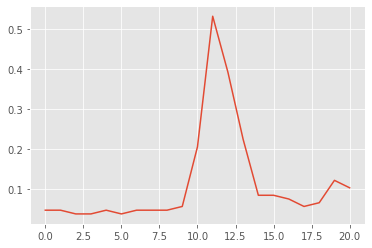

In [ ]:
plot(df_train.loc[0:20, 'Appliances'])

## 3. Data Preparation

In [ ]:
# Prepare the data for RNN model such that the data is presented as (num_samples,seq_length,num_features)

def data_preparation(data,n_past,n_future):
    '''
    input:
        data :[data, time , context inputs, primary inputs, output]
        n_past : number of past steps to be used for prediction
        n_future :  number of steps ahead

    returns:
        context input (Z): 'hours_sin', 'hours_cos' ' weekday_sin' 'weekday_cos'
        primary input (X): 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5',
                  'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9',T_out', 'RH_out', 'Visibility'
        ouput/target (Y): 'Appliances'

    '''

    n,m = data.shape
    print(m,n)


    k = n_future
    t = n_past


    input_data = []
    output_data = []
    context_data = []
    info_data = pd.DataFrame()


    for i in range(t, (n-k+1)):

        context_data.append(data.iloc[i-t:i,2:4]) # context features
        input_data.append(data.iloc[i-t:i, 4:m]) #next remaining attributes are sensor data
        output_data.append([data.iloc[i+k-1:i+k,m-1]])  #last column is the Appliance Energy
        info_data = pd.concat([info_data,data.iloc[i+k-1:i+k,0:2]], axis = 0) #first two columns are date and time




    X = np.array(input_data)
    Y = np.array(output_data)
    Z = np.array(context_data)
    U = info_data  #additional info (date, time) this is required for plots




    #print(n,m)
#    print(X.shape)
#     print(Y.shape)
#     print(Z.shape)


    return X, Y, Z, U


### a) Data preparation - (num_samples, seq_len, num_features)

In [ ]:
df_train.columns

Index(['date', 'time', 'weekday_sin', 'weekday_cos', 'nsm', 'lights', 'T1',
       'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6',
       'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 'RH_9', 'T_out',
       'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint',
       'Appliances'],
      dtype='object')

In [ ]:
cols = ['T9', 'RH_6', 'RH_5', 'RH_3', 'RH_2', 'RH_1']
df_train.drop(cols, axis = 1, inplace = True)
df_val.drop(cols, axis = 1, inplace = True)
df_test.drop(cols, axis = 1, inplace = True)

In [ ]:
X_train, Y_train, Z_train, U_train = data_preparation(df_train, 12, 1)
X_val, Y_val, Z_val, U_val = data_preparation(df_val, 12, 1)
X_test, Y_test, Z_test, U_test = data_preparation(df_test, 12, 1)



25 14209
25 1579
25 3947


In [ ]:
print(X_test.shape)
print(Y_test.shape)
print(Z_test.shape)
print(U_test.head())

(3935, 12, 21)
(3935, 1, 1)
(3935, 12, 2)
          date      time
12  2016-04-30  10:20:00
13  2016-04-30  10:30:00
14  2016-04-30  10:40:00
15  2016-04-30  10:50:00
16  2016-04-30  11:00:00


In [ ]:
df_train.columns

Index(['date', 'time', 'weekday_sin', 'weekday_cos', 'nsm', 'lights', 'T1',
       'T2', 'T3', 'T4', 'RH_4', 'T5', 'T6', 'T7', 'RH_7', 'T8', 'RH_8',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'Appliances'],
      dtype='object')

In [ ]:
if np.any(np.isnan(Z_val)) == True :
    print ('yes')

## 4. Loading data into PyTorch Dataloaders

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size =256

#transform the arrays into torch tensors
train_features = torch.Tensor(X_train)
train_targets = torch.Tensor(Y_train)
train_cx_features = torch.Tensor(Z_train)

val_features = torch.Tensor(X_val)
val_targets = torch.Tensor(Y_val)
val_cx_features = torch.Tensor(Z_val)


train = TensorDataset(train_features,train_cx_features, train_targets)
val = TensorDataset(val_features, val_cx_features,val_targets)


train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

examples = iter(train_loader)
samples,context,targets = examples.next()
print(samples.shape, context.shape,targets.shape)

torch.Size([256, 12, 21]) torch.Size([256, 12, 2]) torch.Size([256, 1, 1])


## 5. Hyperparameter Optimization using Optuna

In [ ]:
#Hyperparameter optimization with optuna


input_dim = X_train.shape[2]
output_dim = Y_train.shape[2]
context_dim = Z_train.shape[2]

weight_decay = 1e-6
dropout = 0.1
n_epochs = 100
batch_size = 256

def objective(trial):

    params1 = {
              'input_dim':input_dim,
              'output_dim': output_dim,
              'context_dim': context_dim,
              'hidden_dim':trial.suggest_int('hidden_size',10,50,5),
              }

    params2 = {
                'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
                'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              }

    #model = get_model('gru',params1)
    model = ContextGRU(input_dim, params1['hidden_dim'], output_dim, context_dim)
    model = model.to(device)


    loss_fn = nn.L1Loss(reduction="mean")
    #optimizer = optim.Adam(model.parameters(), lr=params["learning_rate"], weight_decay=weight_decay)
    optimizer = getattr(optim, params2['optimizer'])(model.parameters(), lr= params2['learning_rate'], weight_decay=weight_decay)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    train_loss = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, np_features=input_dim, nc_features=context_dim)
    opt.plot_losses()


    return train_loss



study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=15)


best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))



## 6. Training

In [1]:

input_dim = X_train.shape[2]
output_dim = Y_train.shape[2]
context_dim = Z_train.shape[2]

hidden_dim = 25
layer_dim = 1
batch_size = 256
dropout = 0.2
n_epochs = 70
learning_rate = 0.0005
weight_decay = 1e-6

model = ContextGRU(input_dim, hidden_dim, output_dim, context_dim)

model = model.to(device)

params_list = model.parameters()

#loss_fn = nn.MSELoss(reduction="mean")
loss_fn = nn.L1Loss(reduction="mean")

#optimizer = optim.Adam(params_list,lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.RMSprop(params_list, lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=weight_decay)
#optimizer = optim.SGD(params_list,lr=learning_rate, weight_decay=weight_decay)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, np_features=input_dim, nc_features=context_dim)
opt.plot_losses()
#opt.visualise_weights()

## Analysis of model weights

In [2]:
# # # Print model's state_dict
# # print("Model's state_dict:")
# # for param_tensor in model.state_dict():
# #     print(param_tensor, "\t", str(model.state_dict()[param_tensor].size()))

# wts, sets, ips = opt.visualise_weights()

# l = len(wts)
# wtmatrix = np.array(wts[l-1])
# fig = plt.figure(figsize=(15, 8))

# for i in range(6) :  #nx = 6 and m = 9

#     plt.subplot(2,3,i+1)

#     sns.heatmap(wtmatrix[:,i*9:i*9+9], cmap = 'Spectral')





## 7. Testing

In [3]:
#parameters from train data statistics
p1 = param1[-1]  #parameter for 'Appliance energy'  (mean/miu)
p2 = param2[-1]  #parameter for 'Appliance energy'  (range/sigma)


test_features = torch.Tensor(X_test)
test_targets = torch.Tensor(Y_test)
test_cx_features = torch.Tensor(Z_test)

test = TensorDataset(test_features,test_cx_features, test_targets)

#test_loader = DataLoader(test, batch_size=X_test.shape[0], shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False)


predictions, values = opt.evaluate(test_loader_one, batch_size=1, np_features=input_dim, nc_features = context_dim)
#flatten the multi-dimension array to 1-D array
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()


target_val = np.reshape(vals,(len(vals),1))
pred_val = np.reshape(preds,(len(preds),1))

result_metrics = calculate_metrics(target_val, pred_val)  #result_metrics is a dictionary

print(f"[norm_RMSE: {result_metrics['rmse']:.4f}]")
print(f"[norm_R2 SCORE: {result_metrics['r2']:.4f}]")
print(f"[norm_MAE: {result_metrics['mae']:.4f}]")

#Apply inverse transform
#reshape vals and preds as inverse transform accepts 2-D array

target_val = inv_trans(np.reshape(vals,(len(vals),1)), "minmax",p1,p2)
pred_val = inv_trans(np.reshape(preds,(len(preds),1)),"minmax",p1,p2)

#plot_results(i, target_val,pred_val)

result_metrics = calculate_metrics(target_val, pred_val)  #result_metrics is a dictionary
print('--------------------------------------')
print(f"[RMSE: {result_metrics['rmse']:.4f}]")
print(f"[R2 SCORE: {result_metrics['r2']:.4f}]")
print(f"[MAE: {result_metrics['mae']:.4f}]")


### Calculate Error Metrics

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(actual, predicted):

    return {'mae' : mean_absolute_error(actual,predicted),
            'rmse' : mean_squared_error(actual,predicted) ** 0.5,
            'r2' : r2_score(actual,predicted)}

# result_metrics = calculate_metrics(target_val, pred_val)
# print(result_metrics)

### Plot results for a specific day

In [ ]:
#get the target values for specific date
print(U_test.date.unique())

[datetime.date(2016, 4, 30) datetime.date(2016, 5, 1)
 datetime.date(2016, 5, 2) datetime.date(2016, 5, 3)
 datetime.date(2016, 5, 4) datetime.date(2016, 5, 5)
 datetime.date(2016, 5, 6) datetime.date(2016, 5, 7)
 datetime.date(2016, 5, 8) datetime.date(2016, 5, 9)
 datetime.date(2016, 5, 10) datetime.date(2016, 5, 11)
 datetime.date(2016, 5, 12) datetime.date(2016, 5, 13)
 datetime.date(2016, 5, 14) datetime.date(2016, 5, 15)
 datetime.date(2016, 5, 16) datetime.date(2016, 5, 17)
 datetime.date(2016, 5, 18) datetime.date(2016, 5, 19)
 datetime.date(2016, 5, 20) datetime.date(2016, 5, 21)
 datetime.date(2016, 5, 22) datetime.date(2016, 5, 23)
 datetime.date(2016, 5, 24) datetime.date(2016, 5, 25)
 datetime.date(2016, 5, 26) datetime.date(2016, 5, 27)]


In [ ]:
#combine Utest,target, and perd_val
#del df_results
df_results = pd.DataFrame()
df_results['target'] = target_val[:,0]
df_results['predicted'] = pred_val[:,0]
# df_results.reset_index(inplace = True)
# U_test.reset_index(inplace = True)
df_results = pd.concat([U_test, df_results], axis = 1)

In [ ]:
df_results.head()

,date,time,target,predicted
12,2016-04-30,10:20:00,570.0,71.669991
13,2016-04-30,10:30:00,610.0,69.373535
14,2016-04-30,10:40:00,330.0,142.087524
15,2016-04-30,10:50:00,350.0,158.549271
16,2016-04-30,11:00:00,260.0,123.877022


In [ ]:
#df_results.drop(columns = ['index', 'level_0'], inplace = True)

In [ ]:
df_results.reset_index(inplace = True)

In [ ]:
df_results['date'] = df_results['date'].astype(str)
df_results['time'] = df_results['time'].astype(str)

In [ ]:
select_date = '2016-05-03'
plot_data1 = df_results[df_results['date'] == select_date]
plot_data1.reset_index(inplace = True)

# select_date = '2016-05-04'
# plot_data2 = df_results[df_results['date'] == select_date]
# plot_data2.reset_index(inplace = True)

plot_data = pd.concat([plot_data1, plot_data2], axis = 0)

In [ ]:
plot_data1.to_csv('plot_data_CiRNN')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


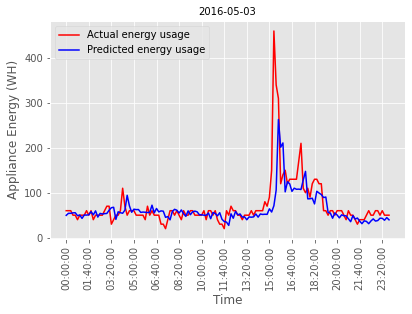

In [ ]:
#plot_results(plot_data, '2016-05-03 and 2016-05-04')
plot_results(plot_data1, '2016-05-03')

In [ ]:
#Plot the results
def plot_results(plot_data, date):

    #data is df with date, time, target, predicted
    #plot_data.reset_index(inplace = True)
    target_val = plot_data['target']
    pred_val = plot_data['predicted']


    fig = plt.figure(figsize=(14, 4))
    #fig = plt.figure()
    ax = plt.subplot(1,2,1)
    #plt.subplot(1,2,1)
    plt.subplot(1,2,1).set_title(date, fontsize= 10)
    ax.plot(target_val,'r')
    ax.plot(pred_val,'b')
    plt.xlabel('Time')
    plt.ylabel('Appliance Energy (WH)')
    plt.legend(['Actual energy usage','Predicted energy usage'])

    ticks = list(range(0,len(plot_data)))
    tick_labels = plot_data['time']
    ax.set_xticks(ticks[::10])
    ax.set_xticklabels(tick_labels[::10])
    ax.tick_params(axis='x', rotation = 90)
    plt.savefig('AEP_result.eps', format = 'eps', dpi = 1000)


